### Setup

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from filtering.enkf import EnKF
from model.linear2D import Linear2D
from model.parameter import Parameter
from utils import default_generator
from utils.plotter import Plotter
from utils.compare import Comparator

Plotter.fig_folder = "figs_linear"

### Linear oscillator

In [2]:
generator = default_generator

init_state = np.array([np.pi / 2, 6.5])
init_state_cov = 0.5 * np.eye(len(init_state))
n_states = len(init_state)
n_obs = 2

p1 = -2
p2 = -0.5
params = [
    Parameter(p1, uncertainty=1, name="$\\theta_1$", estimate=False),
    Parameter(p2, uncertainty=1, name="$\\theta_2$", estimate=False),
]

H = lambda _: np.eye(n_obs)
system_cov = lambda _: 0.1 * np.eye(n_states)
obs_cov = lambda _: 0.3 * np.eye(n_obs)

time_step = 0.01
init_time = 0
end_time = 20

### Generate true state

In [3]:
model = Linear2D(init_state, time_step, params, H, system_cov, obs_cov, generator)
times, states = model.integrate(init_time, end_time)

### Generate observations (with noise)

In [4]:
assimilation_step = 1
assimilation_times = np.linspace(1, end_time, int(end_time / assimilation_step))
observed = np.zeros((n_obs, len(assimilation_times)))
observed_true = np.zeros((n_obs, len(assimilation_times)))
for i, t in enumerate(assimilation_times):
    k = int(t / time_step)
    observed[:, i] = model.observe(states[:, k], add_noise=True)
    observed_true[:, i] = model.observe(states[:, k])

### EnKF twin experiment

100%|██████████| 20/20 [00:04<00:00,  4.45it/s]


Localize: False


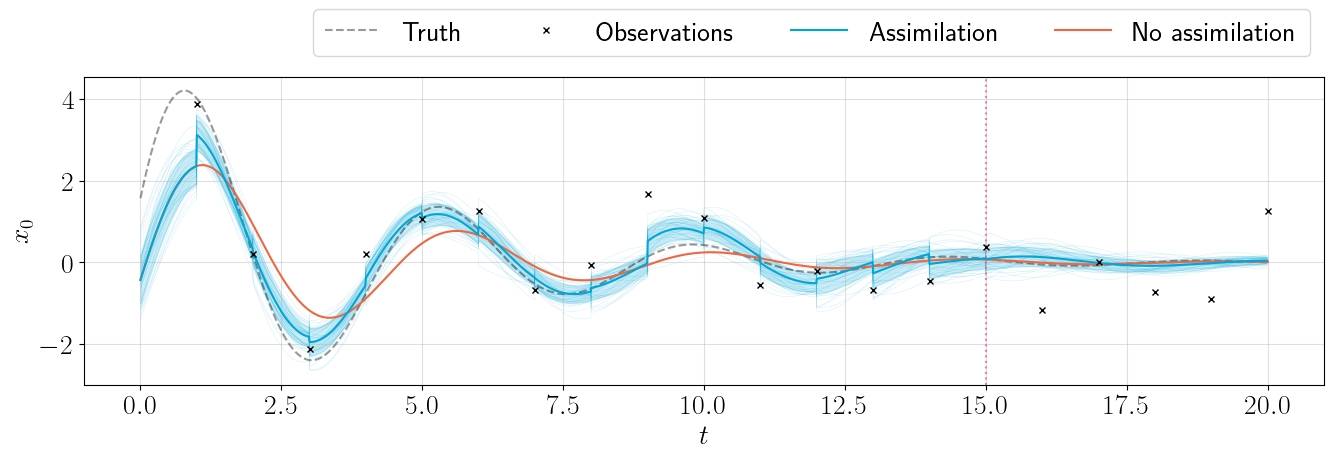

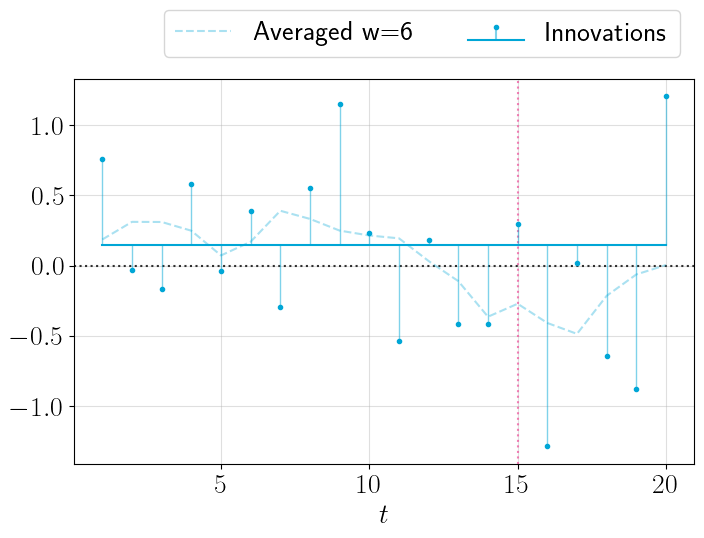

In [5]:
ensemble_size = 40
assimilation_data = observed

init_state += np.array([-2, -2])
model.reset_model(init_state)
times_no_da, states_no_da = model.integrate(init_time, end_time)


model.reset_model(init_state)
f = EnKF(model, init_state, init_state_cov, ensemble_size)

results = f.filter(
    assimilation_times,
    observed,
    cut_off_time=15,
)
results.figsize = "horizontal"
results.true_times = times
results.true_states = states

window = int(end_time / 3)
for i in range(1):
    ax = results.plot_filtering(i, True, True, path=f"filter_x{i}")
    Plotter.plot(
        times_no_da,
        states_no_da[i, :],
        color=Plotter.colors[2],
        label="No assimilation",
        ax=ax,
        path=f"filter_x{i}",
    )
    results.plot_innovations(i, window=window, path=f"innovations_x{i}")

### Add bias to the model

In [6]:
# model.discrete_forcing = lambda t, x: 0.5 * np.ones_like(init_state)
model.offset = lambda t, x: 1 * np.ones_like(init_state)
model.reset_model(init_state)
times_no_da, states_no_da = model.integrate(init_time, end_time)

model.reset_model(init_state)
cut_off_time = 15
f = EnKF(model, init_state, init_state_cov, ensemble_size, generator)
results_biased = f.filter(
    assimilation_times, observed, cut_off_time=cut_off_time, run_id="bias"
)
results_biased.true_times = times
results_biased.true_states = states

100%|██████████| 20/20 [00:04<00:00,  4.41it/s]

Localize: False


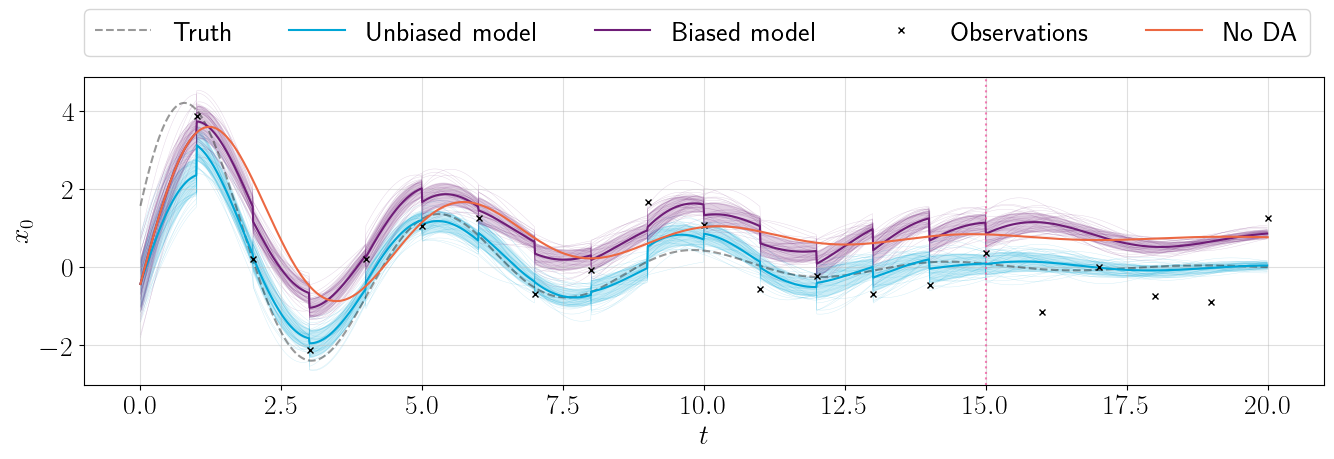

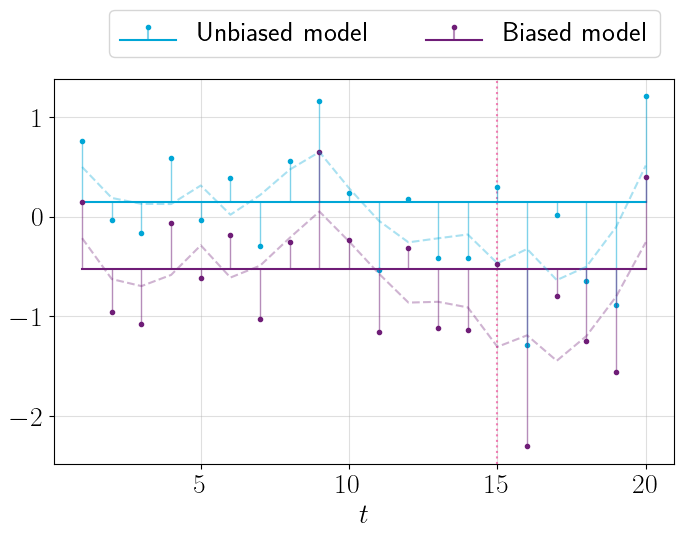

In [7]:
c = Comparator([results, results_biased], ["Unbiased model", "Biased model"])
ax = c.compare_filtering(
    state_idx=0,
    plot_ensemble=True,
    plot_bands=True,
    figsize="horizontal",
)
Plotter.plot(
    times_no_da,
    states_no_da[i, :],
    color=Plotter.colors[2],
    label="No DA",
    ax=ax,
    path="compare_x0",
)
c.compare_innovations(state_idx=0, figsize="standard", window=3, path="compare_inn")
plt.show()